# [문제 1] 수업 자료에서 제시하고 있는 다음 코드들은 Backend AI 또는 Google Colab 등으로 옮겨 실행하고 각 결과를 잘 정리하여 제시하기

### g_crypto_currency_regression_train_lstm.py 실행결과

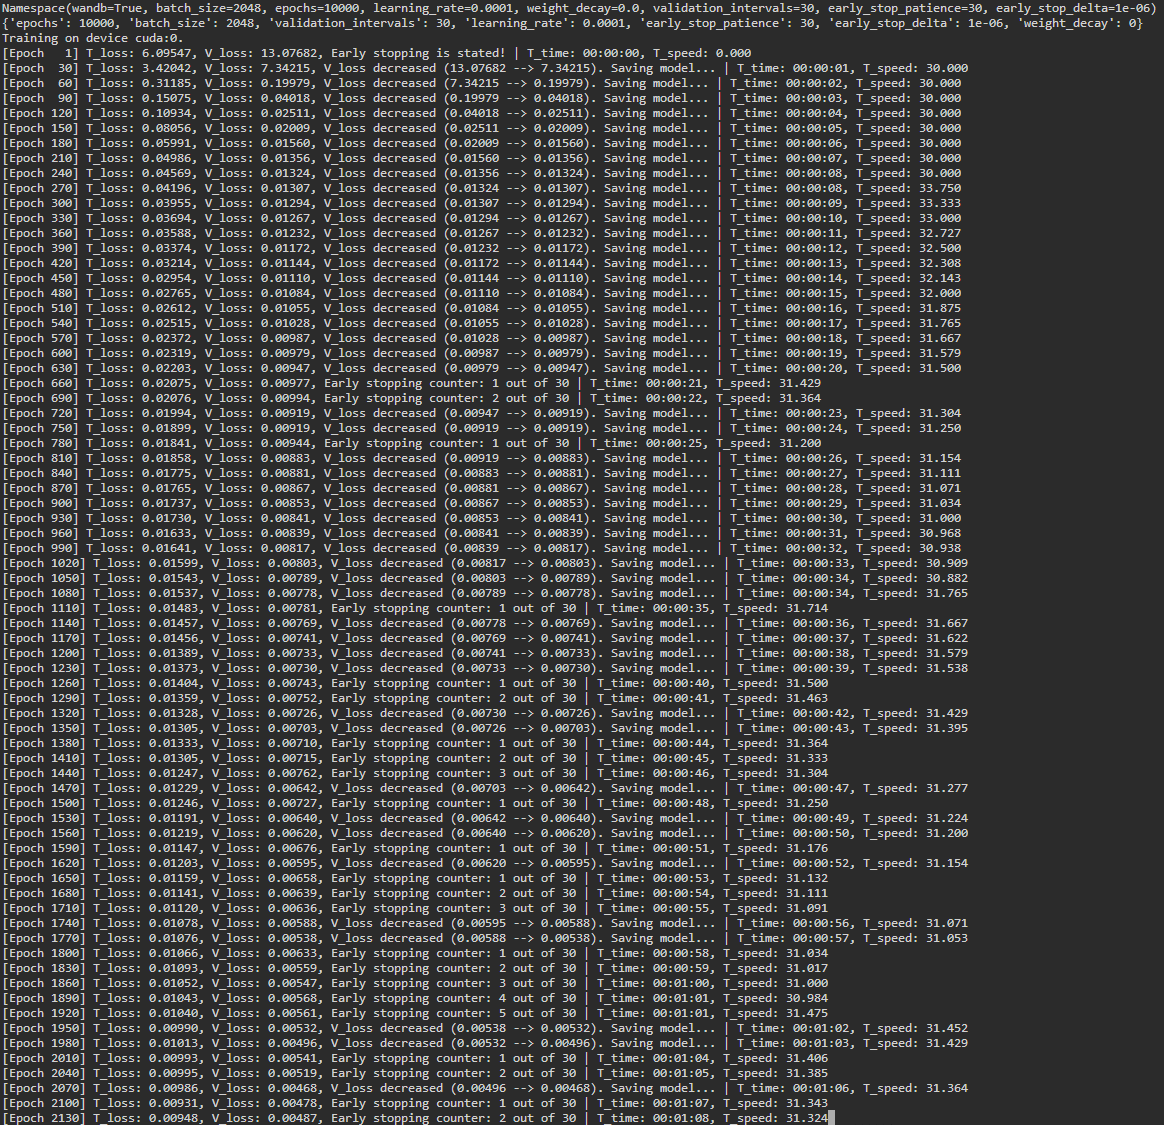
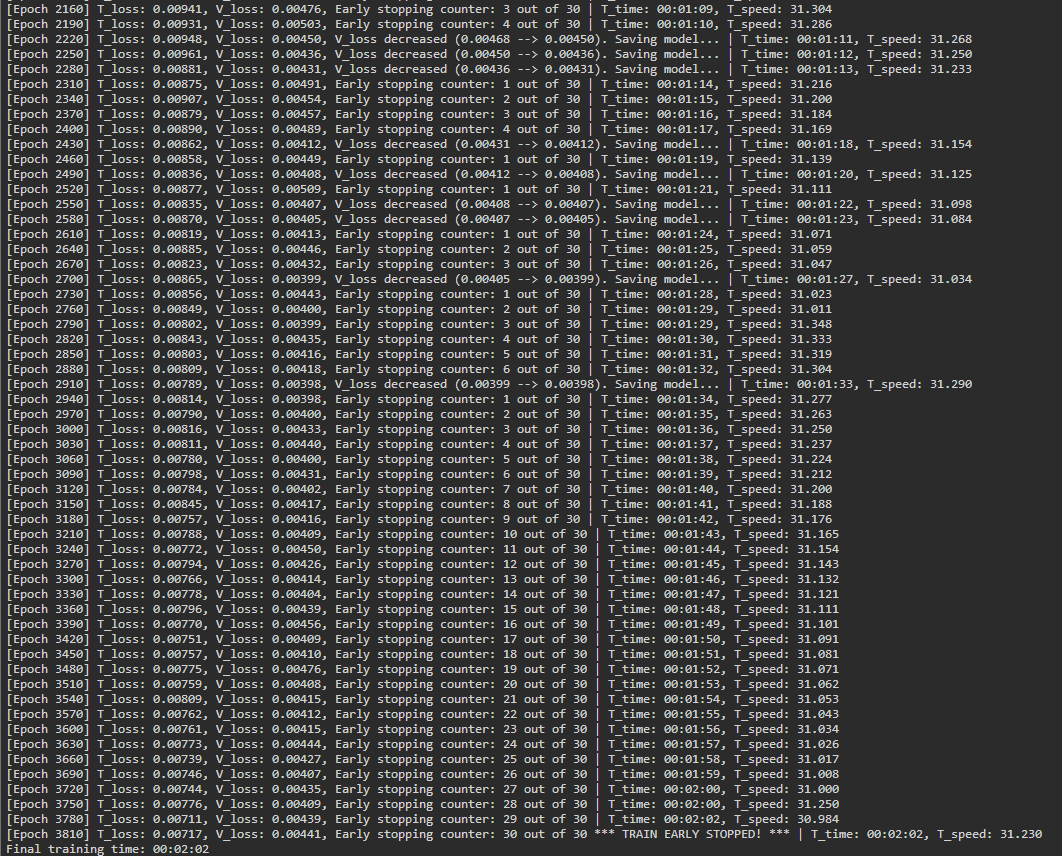

### h_crypto_currency_regression_test_lstm.py 실행결과

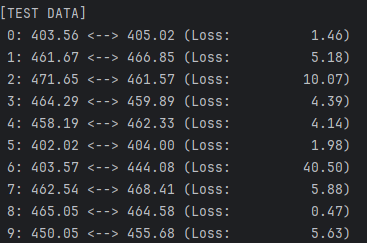

### h_crypto_currency_regression_test_lstm.py 그래프

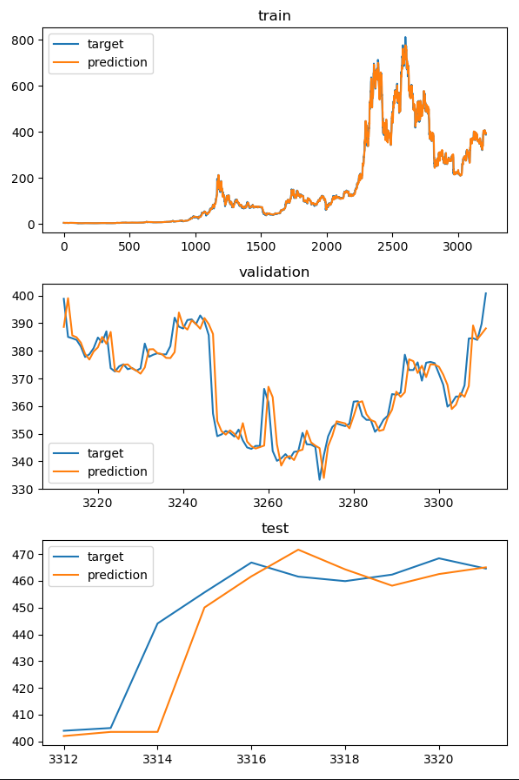

### i_crypto_currency_classification_train_lstm.py 실행결과

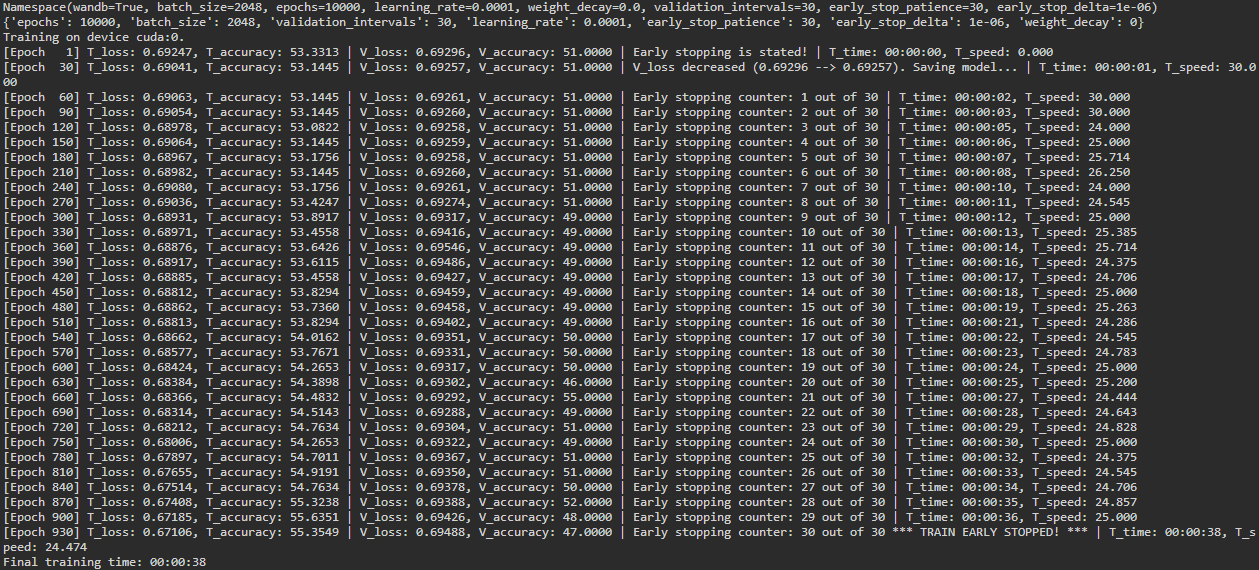

### j_crypto_currency_classification_test_lstm.py 실행결과

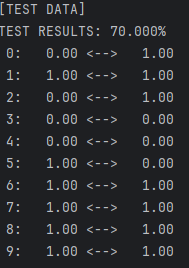

# [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기

In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
import pandas as pd
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import CryptoCurrencyDataset

def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "_03_homeworks", "homework_4", "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path,skiprows=[1,2])
  df=df.rename(columns={'Price':'Date'})

  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])
  df=df[['Open','High','Low','Close','Volume']]
  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=2, batch_first=True,dropout=0.1,bidirectional=True)
      self.fcn = nn.Sequential(
          nn.Linear(in_features=512, out_features=256),
          nn.ReLU(),
          nn.Linear(in_features=256, out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=n_output)
      )

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': 0.0005,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': 1e-5
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb


### 콘솔출력

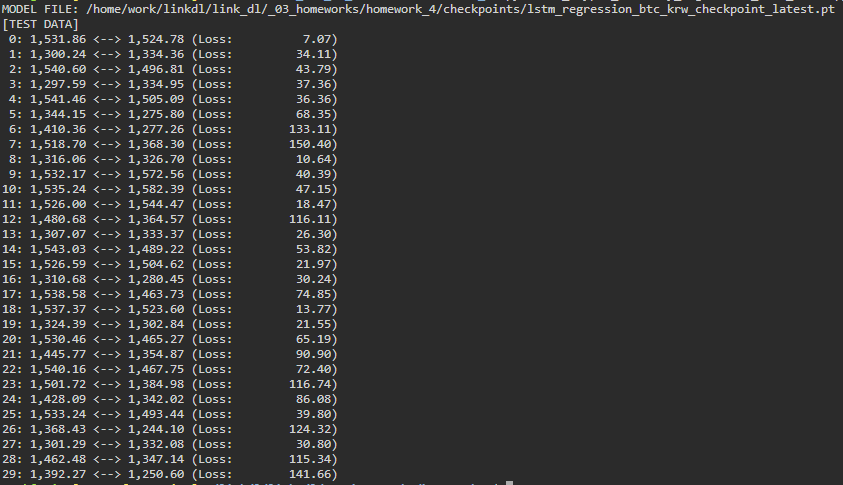

### 출력 그래프

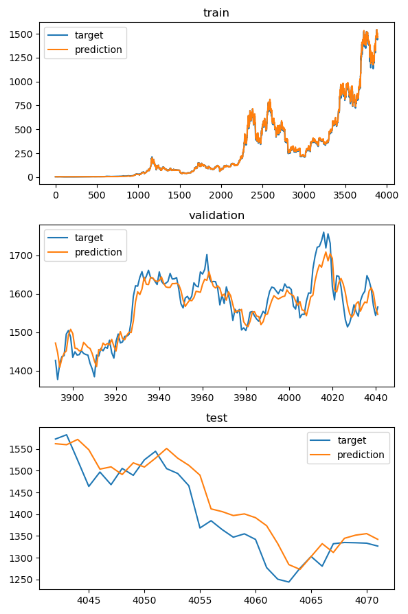

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _03_homeworks.homework_4.g_crypto_currency_regression_train_lstm1 import get_btc_krw_data


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=64, num_layers=2, batch_first=True,dropout=0.1)
      self.fcn = nn.Sequential(
          nn.Linear(in_features=64,out_features=32),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(in_features=32,out_features=n_output)
      )

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size':64,
    'validation_intervals': args.validation_intervals,
    'learning_rate':1e-4,
    'early_stop_patience': 200,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay':1e-5,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm1.py -p 100 -r 0.00001


### 콘솔출력

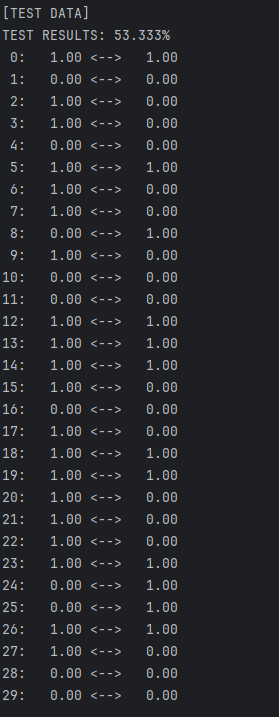

# [문제 3] 데이터 Feature 추가 후 성능 변화 확인하기

In [ ]:
df['Next_Open'] = df['Open'].shift(-1)
df = df.dropna()
df=df[['Open','High','Low','Close','Volume','Next_Open']]
row_size = len(df)
data_size = row_size - sequence_size
train_size = data_size - (validation_size + test_size)

위와 같은 방법으로 Next_Open 추가

### Feature 추가 후(Regression)

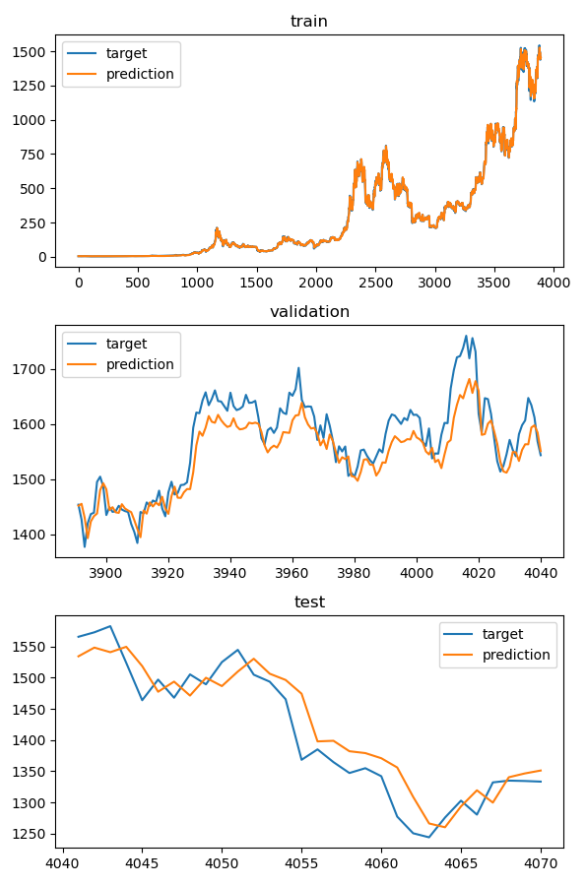

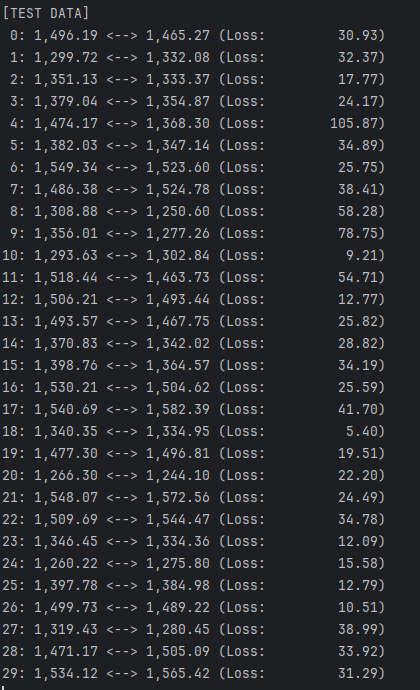

### Feature 추가 후(Classification)

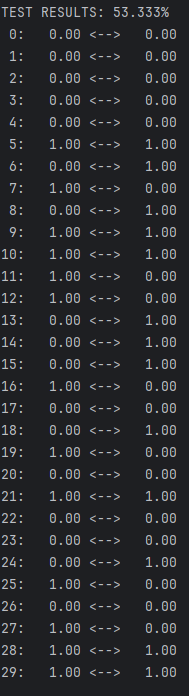

# 숙제후기

이번 과제를 수행하기 전에는 이미지 데이터보다는 더 쉬울 것이라고 생각을 했었다. 하지만 예상과는 다르게 이번 과제 역시 해결하는데 어려움을 많이 겪었다고 생각한다. V_loss가 처음에 한 번만 감소하고 early stopping으로 모델 학습이 끝나는 경우도 있었다. 이때는 classification을 할때 무조건 0아니면 1로 모든 test경우를 처리하길래 매우 당황을 했다. 그래서 이번 과제를 하면서 하이퍼파라미터를 각 데이터에 맞게 그리고 결과를 확인하면서 어떻게 수정해나가는 것이 좋을지 고민을 하는데 시간을 많이 투자했다. 앞으로도 이렇게 모델을 학습시키는 작업을 하게 된다면 고려해야할 점이 많고 되게 섬세하고 깊게 생각해야겠다고 다짐을 하게되었다. 